This dataset (https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data) is a synthetic version inspired by the original Credit Risk dataset on Kaggle and enriched with additional variables based on Financial Risk for Loan Approval data. SMOTENC was used to simulate new data points to enlarge the instances. The dataset is structured for both categorical and continuous features.

# Dataset Description

| Column Name                   | Description                                           | Data Type       |
|-------------------------------|-------------------------------------------------------|-----------------|
| `person_age`                  | Age of the person                                    | Float           |
| `person_gender`               | Gender of the person                                 | Categorical     |
| `person_education`            | Highest education level                              | Categorical     |
| `person_income`               | Annual income                                        | Float           |
| `person_emp_exp`              | Years of employment experience                       | Integer         |
| `person_home_ownership`       | Home ownership status (e.g., rent, own, mortgage)    | Categorical     |
| `loan_amnt`                   | Loan amount requested                                | Float           |
| `loan_intent`                 | Purpose of the loan                                  | Categorical     |
| `loan_int_rate`               | Loan interest rate                                   | Float           |
| `loan_percent_income`         | Loan amount as a percentage of annual income         | Float           |
| `cb_person_cred_hist_length`  | Length of credit history in years                    | Float           |
| `credit_score`                | Credit score of the person                           | Integer         |
| `previous_loan_defaults_on_file` | Indicator of previous loan defaults                | Categorical     |
| `loan_status` (target variable) | Loan approval status: 1 = approved; 0 = rejected   | Integer         |


In [1]:
# Library
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score, roc_curve

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [4]:
df.duplicated().sum()

0

In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,person_age,float64,0,0.0,60,"[35.0, 63.0]"
1,person_gender,object,0,0.0,2,"[female, male]"
2,person_education,object,0,0.0,5,"[Associate, Master]"
3,person_income,float64,0,0.0,33989,"[87064.0, 57427.0]"
4,person_emp_exp,int64,0,0.0,63,"[5, 101]"
5,person_home_ownership,object,0,0.0,4,"[OWN, RENT]"
6,loan_amnt,float64,0,0.0,4483,"[4781.0, 2107.0]"
7,loan_intent,object,0,0.0,6,"[DEBTCONSOLIDATION, EDUCATION]"
8,loan_int_rate,float64,0,0.0,1302,"[7.27, 8.38]"
9,loan_percent_income,float64,0,0.0,64,"[0.59, 0.19]"


<Axes: >

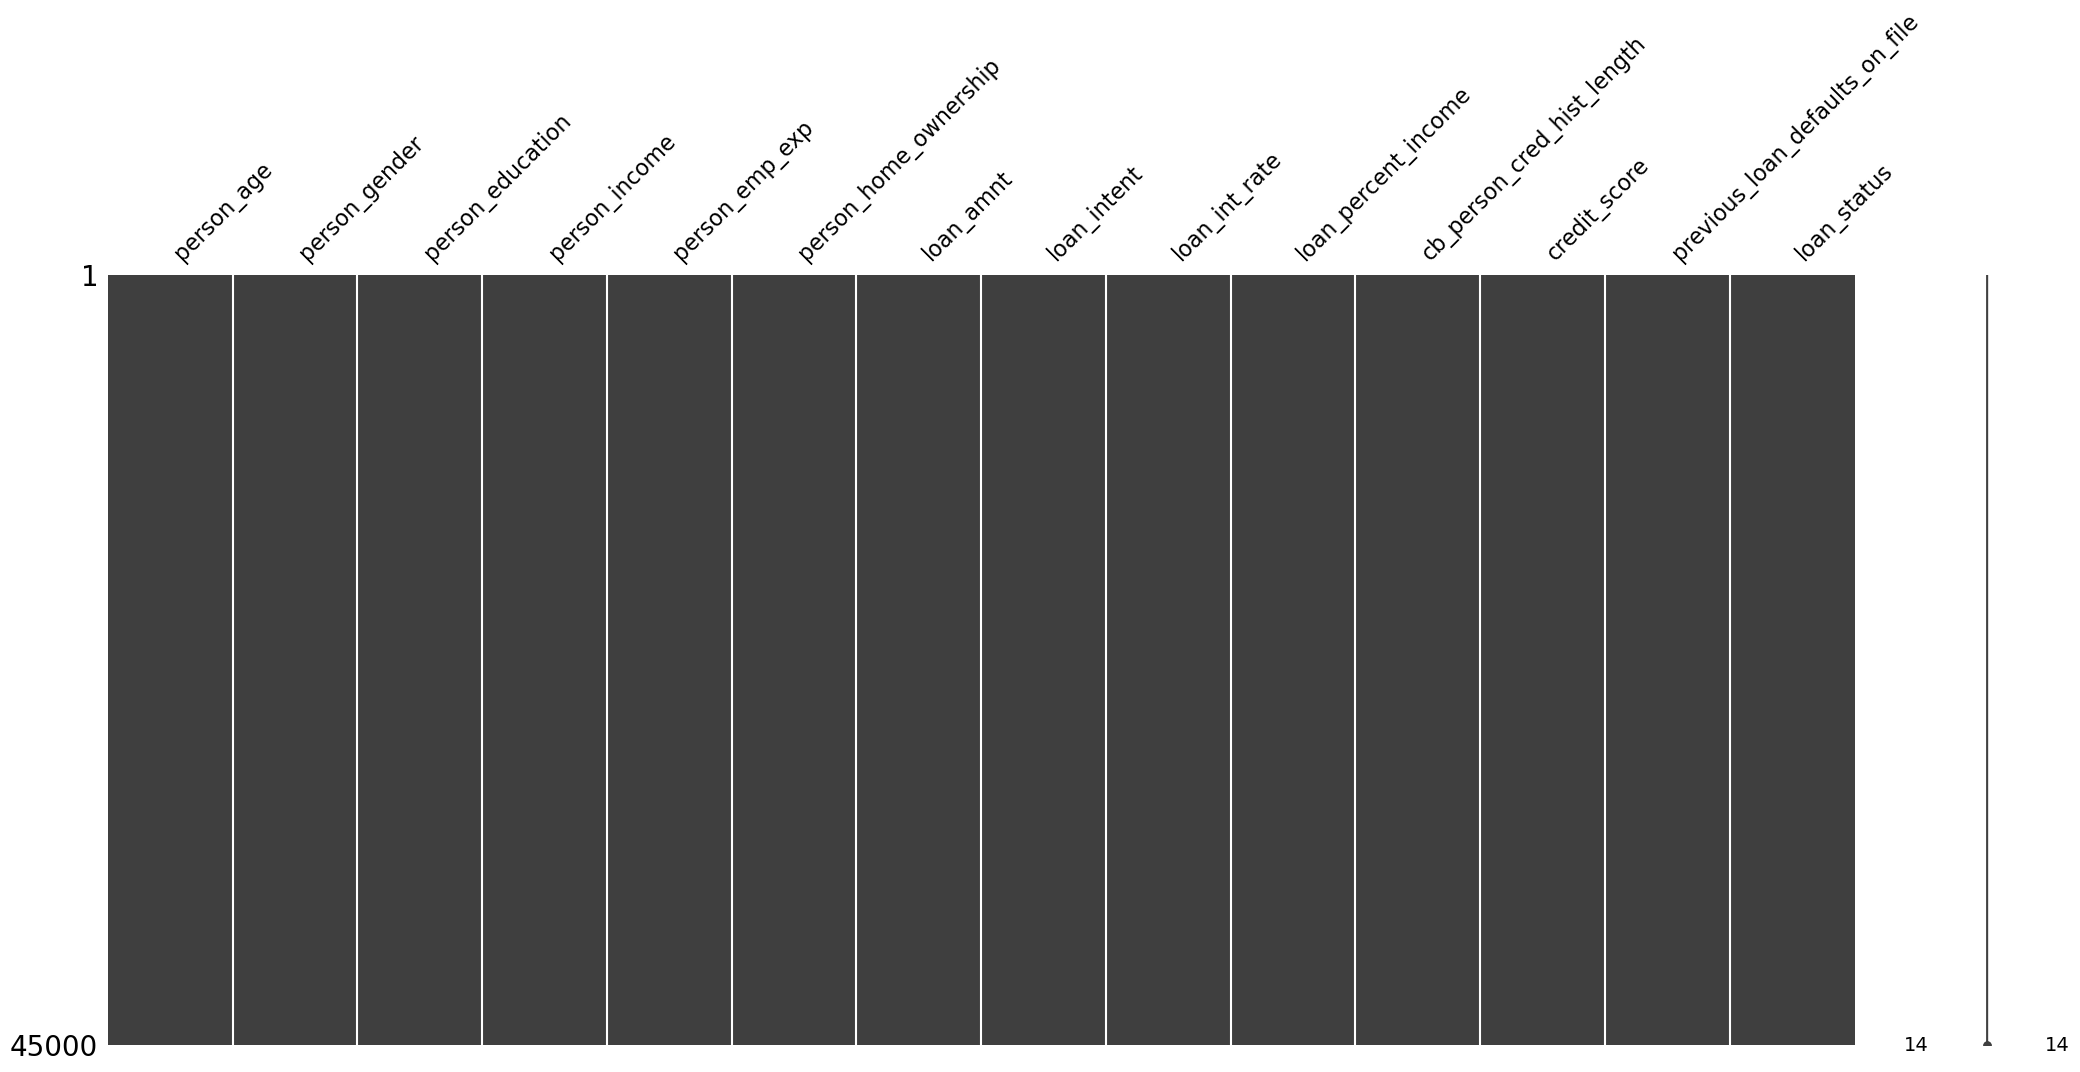

In [6]:
missingno.matrix(df)

In [7]:
def group_cols_by_dtype(df):
    num_cols, cat_cols, dt_cols, bool_cols = [], [], [], []
    
    num_cols.append(df.select_dtypes(include=['int', 'float']).columns.to_list())
    cat_cols.append(df.select_dtypes(include=['object', 'category']).columns.to_list())
    dt_cols.append(df.select_dtypes(include=['datetime']).columns.to_list())
    bool_cols.append(df.select_dtypes(include=['bool']).columns.to_list())
    
    return num_cols, cat_cols, dt_cols, bool_cols

In [8]:
num_cols, cat_cols, dt_cols, bool_cols = group_cols_by_dtype(df)

In [9]:
num_cols

[['person_age',
  'person_income',
  'person_emp_exp',
  'loan_amnt',
  'loan_int_rate',
  'loan_percent_income',
  'cb_person_cred_hist_length',
  'credit_score',
  'loan_status']]

In [10]:
cat_cols

[['person_gender',
  'person_education',
  'person_home_ownership',
  'loan_intent',
  'previous_loan_defaults_on_file']]

In [11]:
df['loan_status'].value_counts()

loan_status
0    35000
1    10000
Name: count, dtype: int64

The results of the check indicate that the data is potentially imbalanced.

In [12]:
def histogram_num_features(df):
    print("Histogram for Numerical Features")
    df[num_cols[0][:-1]].hist(figsize = (20,10), bins=50);
    plt.show();

In [13]:
def boxplot_num_features(df):
    print("Box Plot for Numerical Features")
    for col in num_cols[0][:-1]:
        df[col].plot(kind = 'box');
        plt.show();

Histogram for Numerical Features


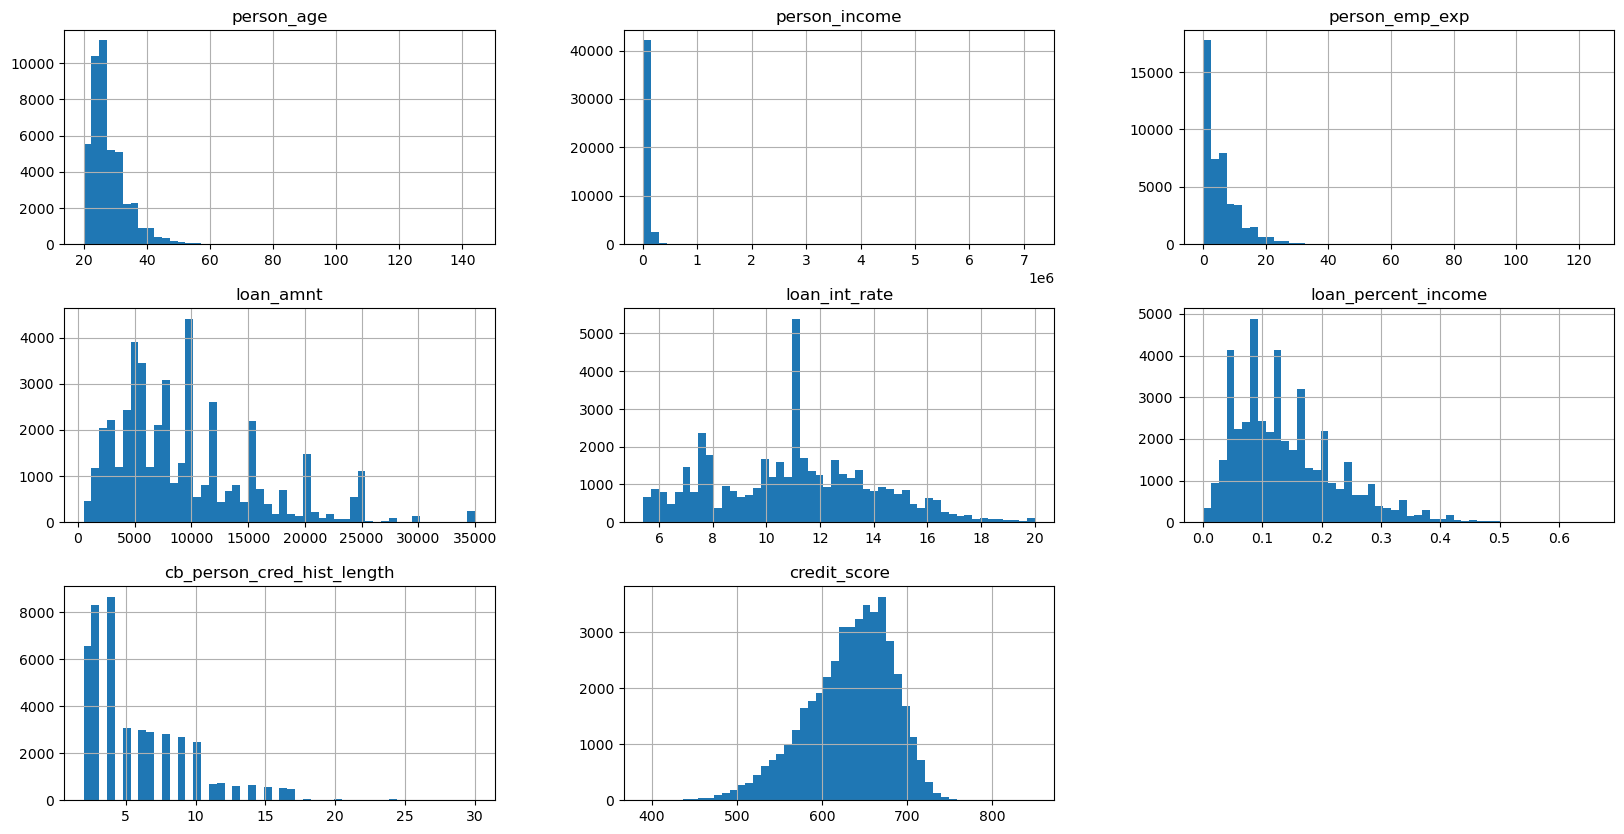

In [14]:
histogram_num_features(df)

Box Plot for Numerical Features


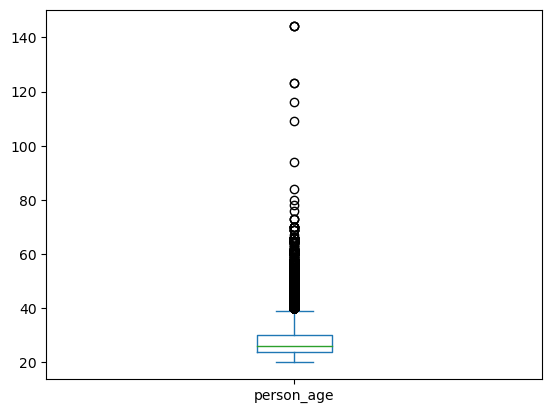

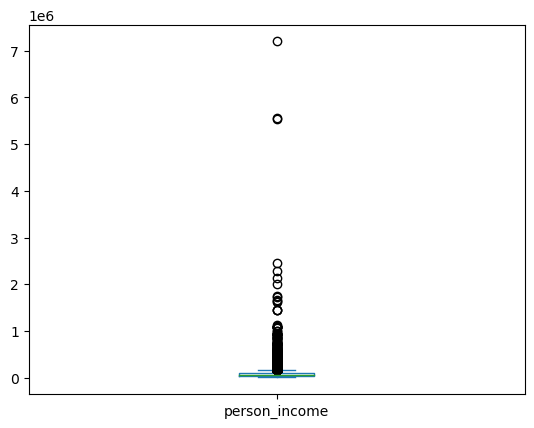

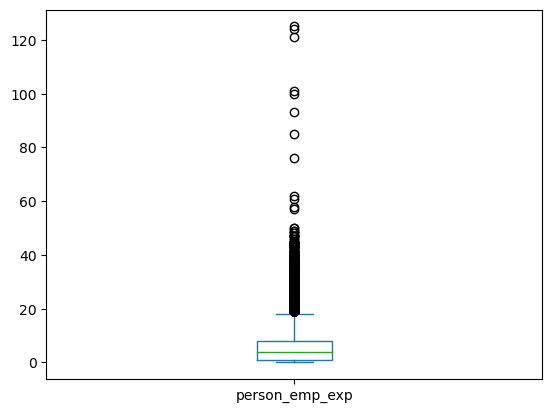

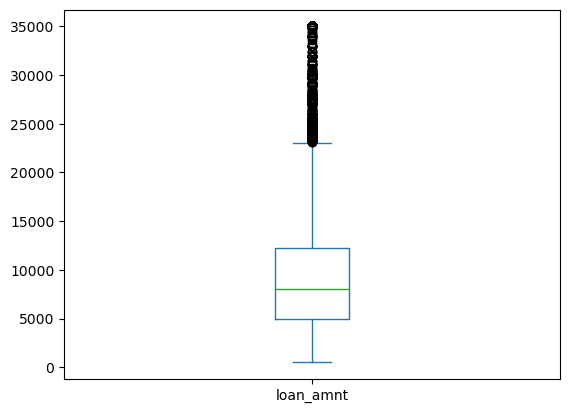

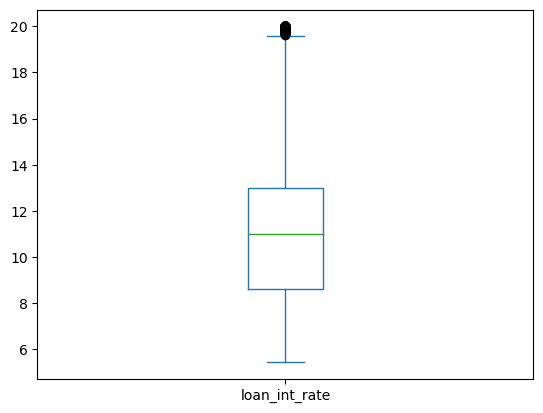

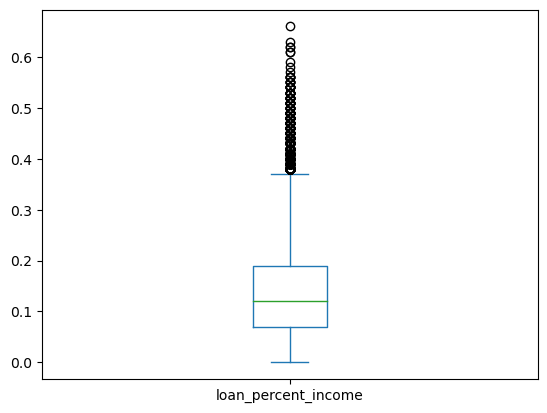

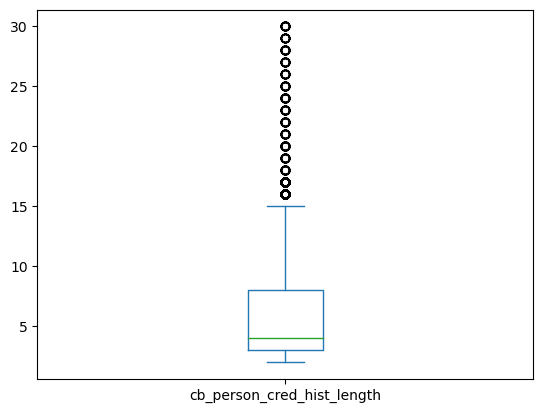

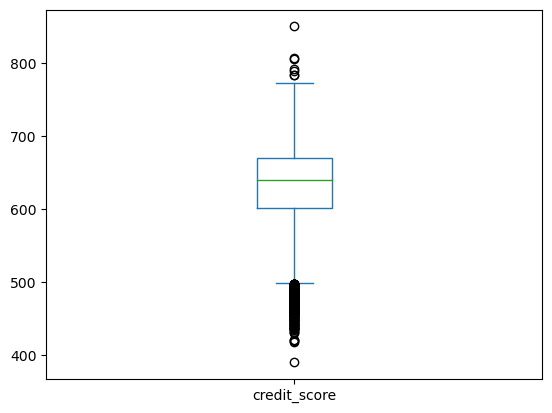

In [15]:
boxplot_num_features(df)

The boxplot and histogram indicate that the data contains many outliers and is not normally distributed.

In [16]:
# Function to identify outliers
def find_outliers(data):
    q1 = np.percentile(data, 25)  # First quartile (25th percentile)
    q3 = np.percentile(data, 75)  # Third quartile (75th percentile)
    iqr = q3 - q1  # Interquartile Range (IQR)
    print(f'IQR: {iqr}')

    lower_limit = q1 - 1.5 * iqr  # Lower bound for outliers
    upper_limit = q3 + 1.5 * iqr  # Upper bound for outliers
    outliers = data[(data < lower_limit) | (data > upper_limit)]  # Identify outliers
    print(f'Lower Limit: {lower_limit}')
    print(f'Upper Limit: {upper_limit}') 
    print(f'Number of outliers: {len(outliers)}')

In [17]:
list_outlier = ['person_age', 
  'person_income',
  'person_emp_exp',
  'loan_amnt',
  'loan_int_rate',
  'loan_percent_income',
  'cb_person_cred_hist_length',
  'credit_score']

for i in list_outlier:
    print('Feature:',i)
    find_outliers(df[i])
    print('=======================')

Feature: person_age
IQR: 6.0
Lower Limit: 15.0
Upper Limit: 39.0
Number of outliers: 2188
Feature: person_income
IQR: 48585.25
Lower Limit: -25673.875
Upper Limit: 168667.125
Number of outliers: 2218
Feature: person_emp_exp
IQR: 7.0
Lower Limit: -9.5
Upper Limit: 18.5
Number of outliers: 1724
Feature: loan_amnt
IQR: 7237.25
Lower Limit: -5855.875
Upper Limit: 23093.125
Number of outliers: 2348
Feature: loan_int_rate
IQR: 4.4
Lower Limit: 1.9899999999999993
Upper Limit: 19.59
Number of outliers: 124
Feature: loan_percent_income
IQR: 0.12
Lower Limit: -0.10999999999999999
Upper Limit: 0.37
Number of outliers: 744
Feature: cb_person_cred_hist_length
IQR: 5.0
Lower Limit: -4.5
Upper Limit: 15.5
Number of outliers: 1366
Feature: credit_score
IQR: 69.0
Lower Limit: 497.5
Upper Limit: 773.5
Number of outliers: 467


In [18]:
# Filtering data 
df = df[(df['person_age'] <= 39.0)]
df = df[(df['person_income'] <= 168667.125)]
df = df[(df['person_emp_exp'] <= 18.5)]
df = df[(df['loan_amnt'] <= 23093.125)]
df = df[(df['loan_int_rate'] <= 19.59)]
df = df[(df['loan_percent_income'] <= 19.59)]
df = df[(df['cb_person_cred_hist_length'] <= 19.59)]
df = df[(df['credit_score'] <= 773.5)]

df = df[(df['person_age'] >= 15.0)]
df = df[(df['loan_int_rate'] >= 1.9899999999999993)]
df = df[(df['credit_score'] >= 497.5)]

In [19]:
for col in cat_cols[0]:
    print("Distribution of", col)
    display(pd.DataFrame(df[col].value_counts()))

Distribution of person_gender


,count
person_gender,
male,21087
female,17393


Distribution of person_education


,count
person_education,
Bachelor,11795
Associate,10126
High School,10031
Master,6091
Doctorate,437


Distribution of person_home_ownership


,count
person_home_ownership,
RENT,20998
MORTGAGE,14848
OWN,2538
OTHER,96


Distribution of loan_intent


,count
loan_intent,
EDUCATION,7957
MEDICAL,7441
VENTURE,6725
PERSONAL,6341
DEBTCONSOLIDATION,6089
HOMEIMPROVEMENT,3927


Distribution of previous_loan_defaults_on_file


,count
previous_loan_defaults_on_file,
Yes,19660
No,18820


<Axes: xlabel='loan_status', ylabel='count'>

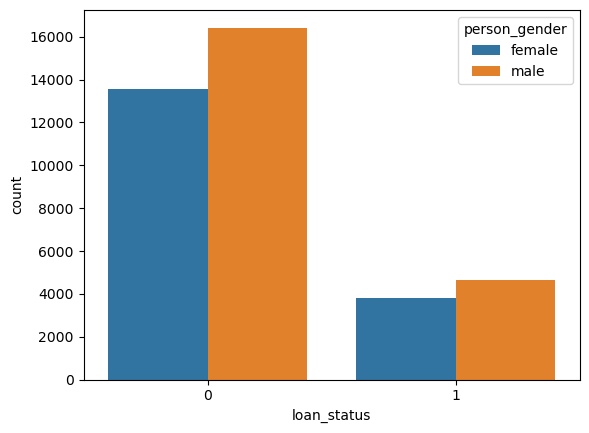

In [20]:
sns.countplot(x='loan_status', hue='person_gender',data=df)

The countplot indicates no differences in loan_status for the loan_gender feature.

<Axes: xlabel='loan_status', ylabel='count'>

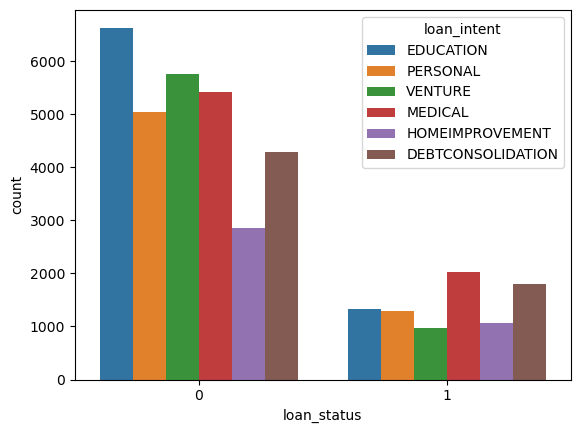

In [21]:
sns.countplot(x='loan_status', hue='loan_intent',data=df)

The countplot shows differences in loan_status based on the loan_intent feature.

<Axes: xlabel='loan_status', ylabel='count'>

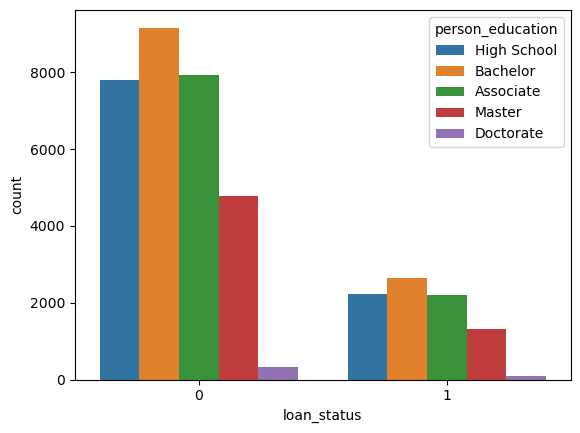

In [22]:
sns.countplot(x='loan_status', hue='person_education',data=df)

The countplot indicates no differences in loan_status for the person_education feature.

<Axes: xlabel='loan_status', ylabel='count'>

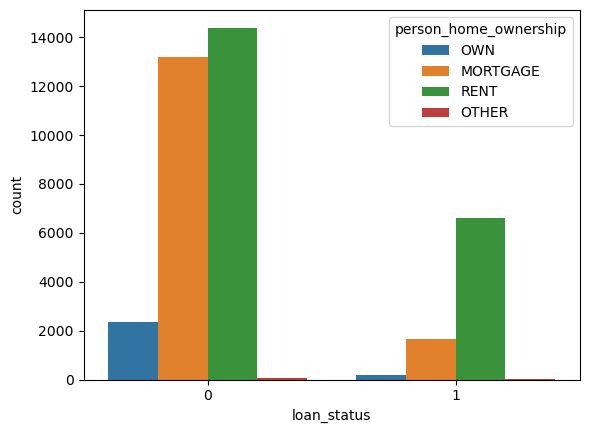

In [23]:
sns.countplot(x='loan_status', hue='person_home_ownership',data=df)

The countplot shows differences in loan_status based on the person_home_ownership feature.

<Axes: xlabel='loan_status', ylabel='count'>

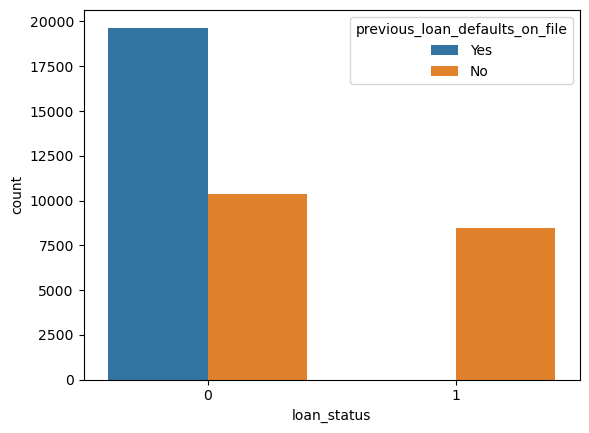

In [24]:
sns.countplot(x='loan_status', hue='previous_loan_defaults_on_file',data=df)

The countplot shows differences in loan_status based on the previous_loan_defaults_on_file feature.

In [25]:
# crosscheck the features
listItem = []

for col in df.columns:
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col]))*100, 2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

df_desc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
df_desc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,person_age,float64,0,0.0,20,"[27.0, 23.0]"
1,person_gender,object,0,0.0,2,"[male, female]"
2,person_education,object,0,0.0,5,"[Master, Associate]"
3,person_income,float64,0,0.0,29171,"[24999.0, 61462.0]"
4,person_emp_exp,int64,0,0.0,19,"[9, 4]"
5,person_home_ownership,object,0,0.0,4,"[OTHER, MORTGAGE]"
6,loan_amnt,float64,0,0.0,3828,"[8254.0, 3225.0]"
7,loan_intent,object,0,0.0,6,"[DEBTCONSOLIDATION, EDUCATION]"
8,loan_int_rate,float64,0,0.0,1260,"[5.5, 16.44]"
9,loan_percent_income,float64,0,0.0,63,"[0.08, 0.52]"


**Data Preparations**

In [26]:
# Check clean dataset
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1
11,21.0,female,Associate,13113.0,0,OWN,4500.0,HOMEIMPROVEMENT,8.63,0.34,2.0,651,No,1


Some categorical features will be converted into dummy variables using one-hot encoding, as the resulting features will not be too numerous, and numerical features will be standardized using a StandardScaler

In [27]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['person_gender','person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']),
], remainder='passthrough')

In [28]:
scaler = StandardScaler()

In [29]:
x = df.drop(columns=['loan_status'])
y = df['loan_status']

In [30]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.2,random_state=2021)

In [31]:
testing = pd.DataFrame(transformer.fit_transform(x_train),columns=transformer.get_feature_names_out())
testing.head()

,onehot__person_gender_male,onehot__person_education_Bachelor,onehot__person_education_Doctorate,onehot__person_education_High School,onehot__person_education_Master,onehot__person_home_ownership_OTHER,onehot__person_home_ownership_OWN,onehot__person_home_ownership_RENT,onehot__loan_intent_EDUCATION,onehot__loan_intent_HOMEIMPROVEMENT,onehot__loan_intent_MEDICAL,onehot__loan_intent_PERSONAL,onehot__loan_intent_VENTURE,onehot__previous_loan_defaults_on_file_Yes,remainder__person_age,remainder__person_income,remainder__person_emp_exp,remainder__loan_amnt,remainder__loan_int_rate,remainder__loan_percent_income,remainder__cb_person_cred_hist_length,remainder__credit_score
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,27.0,39362.0,2.0,8000.0,11.41,0.20,5.0,670.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,31.0,122129.0,9.0,18000.0,8.49,0.15,6.0,710.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.0,115857.0,2.0,4200.0,11.01,0.04,4.0,650.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,26.0,126820.0,6.0,5000.0,7.68,0.04,2.0,700.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,27.0,63279.0,6.0,6225.0,14.35,0.10,7.0,704.0


# Modeling & Evaluation

In [32]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier(verbose=-1)

# Model Benchmarking : K-Fold

In [33]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('scaler', scaler),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
LightGBM,0.976348,0.001901
Random Forest,0.972227,0.002185
Logistic Regression,0.953957,0.002121
KNN,0.921876,0.004645
Decision Tree,0.853289,0.003306
XGBoost,NaN,NaN


# Model Benchmarking : Test Data

In [34]:
from sklearn.metrics import roc_auc_score, classification_report

models = [logreg, knn, dt, rf, xgb, lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator = Pipeline([
        ('preprocess', transformer),
        ('scaler', scaler),
        ('model', i)
    ])
    
    estimator.fit(x_train, y_train)
    return estimator, estimator.predict(x_test), x_test

for i, j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']):
    estimator, y_pred, x_test_transformed = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test_transformed)[:, 1]
    
    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_test, y_predict_proba)
    score_roc_auc.append(roc_auc)
    
    print(j, '\n', classification_report(y_test, y_pred))

# Make dataset with result of ROC AUC
results = pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'roc_auc_score': score_roc_auc
}).set_index('model').sort_values(by='roc_auc_score', ascending=False)

print(results)


Logistic Regression 
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      6001
           1       0.77      0.73      0.75      1695

    accuracy                           0.89      7696
   macro avg       0.85      0.84      0.84      7696
weighted avg       0.89      0.89      0.89      7696

KNN 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      6001
           1       0.80      0.68      0.73      1695

    accuracy                           0.89      7696
   macro avg       0.85      0.82      0.83      7696
weighted avg       0.89      0.89      0.89      7696

Decision Tree 
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      6001
           1       0.76      0.77      0.76      1695

    accuracy                           0.90      7696
   macro avg       0.85      0.85      0.85      7696
weighted avg       0.90      0

From the two benchmarking tests, it can be concluded that the LightGBM model is the best model based on the ROC-AUC score (chosen due to the data being indicated as imbalanced).

# Test Oversampling with K-Fold Cross Validation

In [35]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [36]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [37]:
data = x_train
target = y_train

In [38]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    lgbm = lgb.LGBMClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('scaler', scaler),
        ('model',lgbm)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

In [39]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.950334,0.933745,0.988942,0.976334,0.924747,0.899286,0.833661,0.792035,0.933737,0.895000
1,0.949829,0.931471,0.988925,0.975964,0.924039,0.896368,0.833497,0.793510,0.931502,0.883415
2,0.950695,0.927574,0.989403,0.976525,0.925379,0.890848,0.835955,0.789086,0.933224,0.869919
3,0.949468,0.934070,0.989063,0.980635,0.923307,0.899838,0.829564,0.793510,0.933604,0.895175
4,0.948964,0.925601,0.988774,0.975984,0.922580,0.886606,0.829072,0.769912,0.931676,0.877311
5,0.950949,0.920728,0.989313,0.971605,0.925615,0.879667,0.833989,0.764012,0.936339,0.860465
6,0.950408,0.928850,0.989059,0.977332,0.924943,0.892182,0.835300,0.784661,0.932492,0.879339
7,0.949433,0.931774,0.989030,0.976826,0.923336,0.896435,0.830875,0.789086,0.932157,0.888704
8,0.949506,0.932749,0.989086,0.976219,0.923766,0.897261,0.836447,0.783186,0.927157,0.898477
9,0.950300,0.936322,0.989032,0.978867,0.924563,0.902664,0.831367,0.790560,0.935805,0.908475


In [40]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2401
           1       0.74      0.90      0.81       678

    accuracy                           0.91      3079
   macro avg       0.85      0.91      0.88      3079
weighted avg       0.92      0.91      0.91      3079

              precision    recall  f1-score   support

           0       0.97      0.90      0.94      2401
           1       0.73      0.90      0.81       678

    accuracy                           0.90      3079
   macro avg       0.85      0.90      0.87      3079
weighted avg       0.92      0.90      0.91      3079

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2401
           1       0.75      0.91      0.82       678

    accuracy                           0.91      3079
   macro avg       0.86      0.91      0.88      3079
weighted avg       0.92      0.91      0.92      3079

              preci

# Hyperparameter Tuning

In [41]:
lgbm = lgb.LGBMClassifier()
ros = RandomOverSampler(random_state=42)

estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('scaler', scaler),
    ('model',lgbm)
])

In [42]:
hyperparam_space=[{
    'model__max_bin': [255, 275, 300, 230],
    'model__num_leaves':[31, 21, 41, 51],
    'model__min_data_in_leaf': [20, 15, 30, 40],
    'model__num_iterations':[100,75, 125, 150],
    'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
    'model__random_state': [42]
}]

In [43]:
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='roc_auc', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

In [44]:
grid.fit(x_train,y_train)
print(grid.best_score_)
print(grid.best_params_)

0.9771800019462965
{'model__learning_rate': 0.1, 'model__max_bin': 275, 'model__min_data_in_leaf': 15, 'model__num_iterations': 150, 'model__num_leaves': 51, 'model__random_state': 42}


In [45]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['person_gender',
                                                   'person_education',
                                                   'person_home_ownership',
                                                   'loan_intent',
                                                   'previous_loan_defaults_on_file'])])),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(max_bin=275, min_data_in_leaf=15,
                                num_iterations=150, num_leaves=51,
                                random_state=42))])

In [47]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('scaler', scaler),
    ('model',lgbm)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['person_gender',
                                                   'person_education',
                                                   'person_home_ownership',
                                                   'loan_intent',
                                                   'previous_loan_defaults_on_file'])])),
                ('scaler', StandardScaler()), ('model', LGBMClassifier())])

In [48]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LGBM : ', roc_auc_default)
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

ROC AUC Score Default LGBM :  0.9749667090883083
ROC AUC Score Tuned LGBM :  0.9763115193682076


In [49]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Default LGBM : 
               precision    recall  f1-score   support

           0       0.97      0.90      0.93      6001
           1       0.72      0.90      0.80      1695

    accuracy                           0.90      7696
   macro avg       0.85      0.90      0.87      7696
weighted avg       0.91      0.90      0.90      7696

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      6001
           1       0.76      0.88      0.82      1695

    accuracy                           0.91      7696
   macro avg       0.87      0.90      0.88      7696
weighted avg       0.92      0.91      0.92      7696



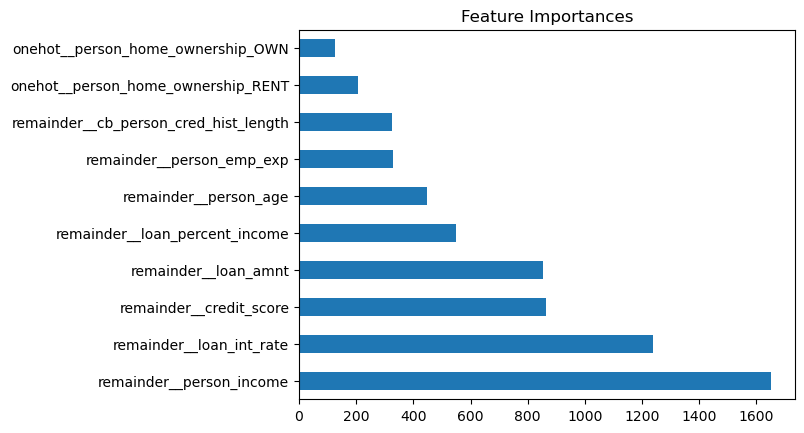

In [50]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

In [51]:
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      6001
           1       0.76      0.88      0.82      1695

    accuracy                           0.91      7696
   macro avg       0.87      0.90      0.88      7696
weighted avg       0.92      0.91      0.92      7696



In [52]:
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

ROC AUC Score Tuned LGBM :  0.9763115193682076


The classification report for the tuned LightGBM model indicates the following:

1. Class 0 (Negative Class):
    - Precision: 0.97, indicating that most predictions for Class 0 were correct.
    - Recall: 0.92, showing that 92% of actual Class 0 cases were correctly identified.
    - F1-Score: 0.94, reflecting a strong balance between precision and recall.
2. Class 1 (Positive Class):
    - Precision: 0.76, meaning 76% of the predicted positive cases were accurate.
    - Recall: 0.88, showing that 88% of actual Class 1 cases were correctly identified.
    - F1-Score: 0.82, indicating a good trade-off between precision and recall for the positive class.
    
3. Overall Performance:
    - Accuracy: 91%, demonstrating that the model performs well in classifying the data overall.
    - Macro Average (Precision, Recall, F1-Score): 0.87, 0.90, and 0.88, respectively, highlighting balanced performance across both classes.
    - Weighted Average: Similar to the macro average, these metrics confirm the model's robust performance, weighted by the class distribution.

# Conclusion:
The tuned LightGBM model performs exceptionally well for the majority class (Class 0) and reasonably well for the minority class (Class 1). While recall for Class 1 is high, the precision for this class is lower, indicating a slight trade-off. Given the imbalanced nature of the data, the model prioritizes correctly identifying positive cases (high recall) at the cost of some false positives.